# Churn Prediction

Entender o motivo pelo qual os seus clientes param de adquirir o seu produto ou serviço é algo essencial para que o negócio se mantenha saúdavel, lucrativo e para que faça sucesso. É necessário que o número de novos clientes seja maior do que a taxa de clientes que cancelaram, chamada de Churn Rate. Para calcularmos esta taxa, basta dividirmos o número total de clientes desistentes pelo número total de clientes ativos do último mês. 
Podemos também calcular o MRR Churn, que é referente à receita do negócio, dividindo a soma dos valores que os clientes que cancelaram pagavam pela soma dos valores pagos por todos os clientes ativos no último mês.

Como o custo de aquisição de um novo cliente é mais alto do que para manter um já existente, identificar possíveis cancelamentos previamente e adotar medidas para evitá-los é algo de extrema importância para um negócio.

## Aquisição dos Dados

Os dados que usaremos neste projeto foram originalmente disponibilizados na plataforma de ensino da [IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O conjunto de dados completo pode ser obtido no [Kaggle](https://www.kaggle.com/blastchar/telco-customer-churn/data).

Começaremos importando as bibliotecas e os dados que utilizaremos.

In [1]:
# importando as bibliotecas necessárias

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('dark')

In [2]:
# importando os dados para um dataframe

url = "datasets/churn.csv"
df = pd.read_csv(url)

Após importarmos os dados para um dataframe, vamos visualizar as 5 primeiras entradas do conjunto de dados.

In [3]:
# visualizando as 5 primeiras entradas

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Análise Exploratória dos Dados

Começaremos a análise visualizando os nomes das colunas e seus tipos de dados, além da quantidade de linhas e colunas do conjunto de dados. 

In [4]:
# visualizando os nomes e os tipos de dados das colunas do dataframe

df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
# obtendo a quantidade de linhas e colunas do dataframe

df.shape

(7043, 21)

Como podemos ver, o nosso dataframe possui 7043 linhas e 21 colunas. A fim de identificarmos possíveis variáveis categóricas, iremos obter a quantidade de valores únicos por coluna.

In [6]:
# obtendo a quantidade de valores diferentes por coluna

df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

Vamos verificar se o nosso conjunto de dados possui valores faltantes.

In [7]:
# verificando se há valores faltantes

df.isnull().sum().values.sum()

0

Como vimos anteriormente, cada linha do dataframe representa um cliente e cada coluna contém informações referentes à assinatura realizada pelo cliente. Pudemos ver também que a coluna 'TotalCharges', que é referente ao valor total que já foi cobrado ao cliente, está no formato 'object', apesar de ser um valor numérico. Portanto, para podermos trabalhar com estes dados numéricos, converteremos a coluna para o tipo de dado 'float'. Criaremos uma função para esta conversão.

In [8]:
# criando uma função para converter os valores

def str_to_float(value):
    
    try:
        return float(value)
    except ValueError:
        return np.nan
    
# convertendo os valores utilizando a função

df_clean = df.copy()
df_clean['TotalCharges'] = df_clean['TotalCharges'].apply(str_to_float)

Após a conversão, vamos verificar se houve tentativa de converter algum valor não numérico em numérico. Se identificada, aplicaremos a mediana de todos os valores numéricos da coluna para estes valores não numéricos.

In [9]:
# verificando se há valores não numéricos na coluna 'TotalCharges'

df_clean['TotalCharges'].isnull().sum()

11

In [10]:
# salvando a mediana dos valores da coluna 'TotalCharges'

totalChargesMedian = df_clean['TotalCharges'].median()

# preenchendo os valores não numéricos com a mediana

df_clean['TotalCharges'].fillna(totalChargesMedian, inplace = True)

Feito isso, apagaremos a coluna 'costumerID' pois não a utilizaremos para esta análise.

In [11]:
# removendo a coluna 'costumerID'

df_clean.drop('customerID', axis = 1, inplace = True)

Agora, iremos olhar quais são os valores que estão contidos em algumas das colunas, referentes a serviços, que informam se o cliente adquiriu ou não um serviço em específico.

In [12]:
# obtendo os valores da coluna 'OnlineSecurity'

df_clean['OnlineSecurity'].value_counts()

No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64

In [13]:
# obtendo os valores da coluna 'OnlineBackup'

df_clean['OnlineBackup'].value_counts()

No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64

In [14]:
# obtendo os valores da coluna 'DeviceProtection'

df_clean['DeviceProtection'].value_counts()

No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64

In [15]:
# obtendo os valores da coluna 'TechSupport'

df_clean['TechSupport'].value_counts()

No                     3473
Yes                    2044
No internet service    1526
Name: TechSupport, dtype: int64

In [16]:
# obtendo os valores da coluna 'StreamingTV'

df_clean['StreamingTV'].value_counts()

No                     2810
Yes                    2707
No internet service    1526
Name: StreamingTV, dtype: int64

In [17]:
# obtendo os valores da coluna 'StreamingMovies'

df_clean['StreamingMovies'].value_counts()

No                     2785
Yes                    2732
No internet service    1526
Name: StreamingMovies, dtype: int64

Assumindo a premissa de que os clientes que não possuem o serviço de internet também não possuem um serviço em específico, substituiremos os valores 'No internet service' por 'No' das colunas acima analisadas.

In [18]:
# substituindo 'No internet service' por 'No' das colunas definidas

col_names = ['OnlineSecurity', \
             'OnlineBackup', \
             'DeviceProtection', \
             'TechSupport', \
             'StreamingTV', \
             'StreamingMovies']

for i in col_names:
    df_clean[i] = df_clean[i].replace({'No internet service' : 'No'})

A coluna 'tenure' é referente ao número de meses em que o cliente contratou o serviço. A fim de inserirmos uma nova coluna categórica, criaremos uma coluna com faixas temporais de permanência no serviço. Para isto, criaremos uma nova função.

In [19]:
# criando uma função para classificação por faixa temporal

def set_tenure_category(v):
    
    if (v <= 12):
        return 'Tenure_0-12'
    elif (v > 12) & (v <= 24):
        return 'Tenure_13-24'
    elif (v > 24) & (v <= 48):
        return 'Tenure_25-48'
    elif (v > 48) & (v <= 60):
        return 'Tenure_49-60'
    elif (v > 60):
        return 'Tenure_qt_60'

In [20]:
# criando uma nova coluna com os valores por faixa

df_clean['tenure_group'] = df_clean['tenure'].apply(set_tenure_category)

Este conjunto de dados é composto majoritariamente por variáveis binárias ou categóricas, e é possível ver abaixo, pelo método describe, que não há indícios da presença de outliers.

In [21]:
# obtendo um resumo estatístico

df_clean.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


Confirmando a ausência de outliers:

In [22]:
# aplicando o cálculo do 1.5 x IQR na coluna 'TotalCharges'

Q1 = df_clean['TotalCharges'].quantile(q = 0.25)
Q3 = df_clean['TotalCharges'].quantile(q = 0.75)

IQR = Q3 - Q1
print(Q3 + 1.5 * IQR)
print(Q1 - 1.5 * IQR)

8863.1625
-4674.3375


In [23]:
# aplicando o cálculo do 1.5 x IQR na coluna 'MonthlyCharges'

Q1 = df_clean['MonthlyCharges'].quantile(q = 0.25)
Q3 = df_clean['MonthlyCharges'].quantile(q = 0.75)

IQR = Q3 - Q1
print(Q3 + 1.5 * IQR)
print(Q1 - 1.5 * IQR)

171.375
-46.02499999999999


Enfim, plotaremos gráficos de caixa para as colunas 'MonthlyCharges' e 'TotalCharges'.

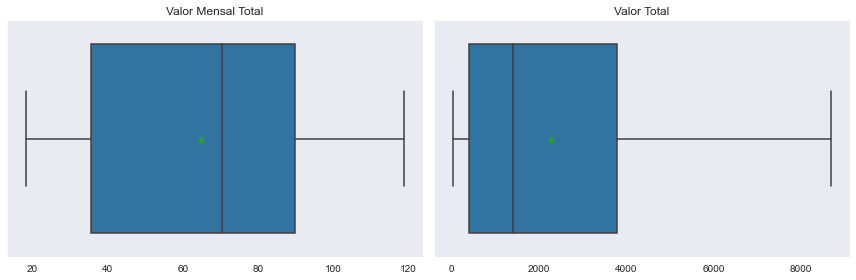

In [24]:
# plotando boxplots para as colunas 'MonthlyCharges' e 'TotalCharges'

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))
sns.boxplot(df_clean['MonthlyCharges'], ax = ax[0], showmeans = True)
sns.boxplot(df_clean['TotalCharges'], ax = ax[1], showmeans = True)
ax[0].set_title('Valor Mensal Total')
ax[1].set_title('Valor Total')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
plt.tight_layout()

## Visualização de dados

Veremos agora, gerando gráficos, quais informações podemos obter a partir do conjunto de dados.

No gráfico de distribuição abaixo, podemos ver a distribuição dos valores pagos mensalmente pelos clientes.

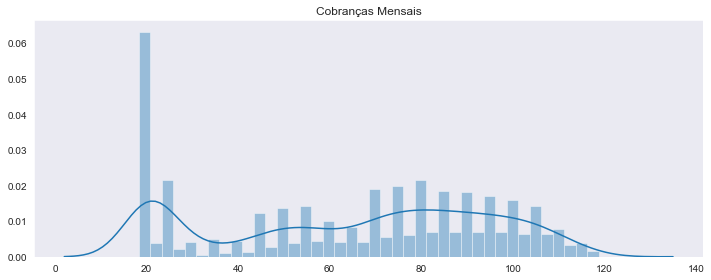

In [25]:
# gerando um gráfico de distribuição para a coluna 'MonthlyCharges'

fig, ax = plt.subplots(figsize = (10, 4))
sns.distplot(df_clean['MonthlyCharges'], ax = ax, bins = 40)
ax.set_xlabel('')
ax.set_title('Cobranças Mensais')
plt.tight_layout()

Já neste outro gráfico, podemos ver a distribuição de todos os valores pagos pelos clientes.

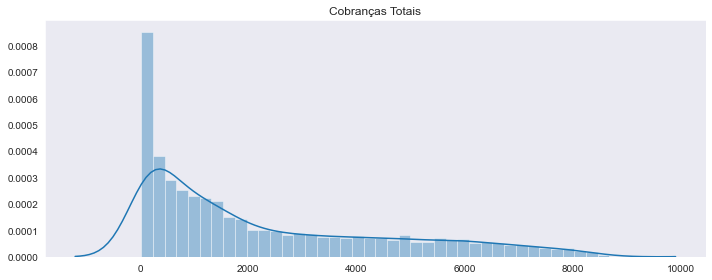

In [26]:
# gerando um gráfico de distribuição para a coluna 'TotalCharges'

fig, ax = plt.subplots(figsize = (10, 4))
sns.distplot(df_clean['TotalCharges'], ax = ax, bins = 40)
ax.set_xlabel('')
ax.set_title('Cobranças Totais')
plt.tight_layout()

Agora, gerando um gráfico de barras, podemos ver que, dentre as faixas temporais de permanência no serviço criadas para esta análise, aquelas com mais clientes registrados foram 'Entre 0 a 12 meses' e 'Entre 25 e 48 meses'.

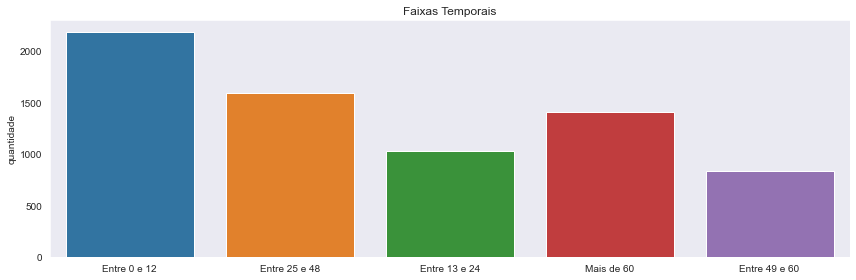

In [27]:
# gerando um gráfico de barras da coluna 'tenure_group'

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title('Faixas Temporais')
sns.countplot(df_clean['tenure_group'], ax = ax)
ax.set_xticklabels(('Entre 0 e 12', 'Entre 25 e 48', 'Entre 13 e 24', 'Mais de 60', 'Entre 49 e 60'))
ax.set_xlabel('')
ax.set_ylabel('quantidade')
plt.tight_layout()

Neste outro gráfico de barras podemos ver que o tipo de contrato mais assinado foi o de assinatura mensal.

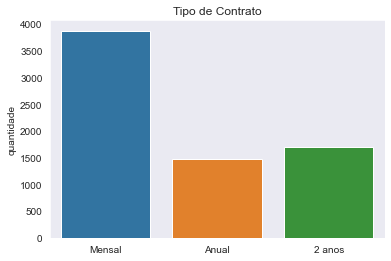

In [28]:
# gerando um gráfico de barras da coluna 'Contract'

fig, ax = plt.subplots()
ax.set_title('Tipo de Contrato')
sns.countplot('Contract', data = df_clean, ax = ax)
ax.set_xticklabels(('Mensal', 'Anual', '2 anos'))
ax.set_xlabel('')
ax.set_ylabel('quantidade')
plt.show()

Vemos também que a forma de pagamento mais utilizado foi a de 'Electronic check'.

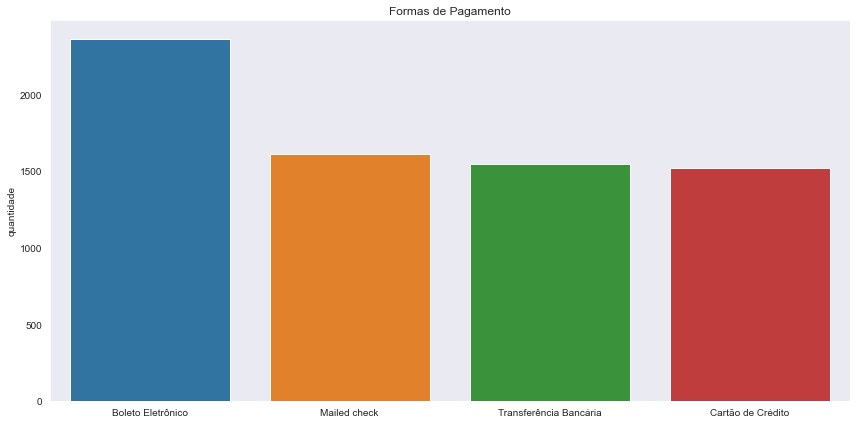

In [29]:
# gráfico de barras da coluna 'Electronic check'

fig, ax = plt.subplots(figsize = (12, 6))
ax.set_title('Formas de Pagamento')
sns.countplot('PaymentMethod', data = df_clean, ax = ax)
ax.set_xticklabels(('Boleto Eletrônico', 'Mailed check', 'Transferência Bancária', 'Cartão de Crédito'))
ax.set_xlabel('')
ax.set_ylabel('quantidade')
plt.tight_layout()

Gerando mais dois gráficos de barras, podemos ver que a porcentagem de clientes idosos é muito baixa em relação a de não idosos. Já quanto ao gênero, podemos ver que a diferença é mínima, com uma pequena vantagem no número de clientes do sexo masculino.

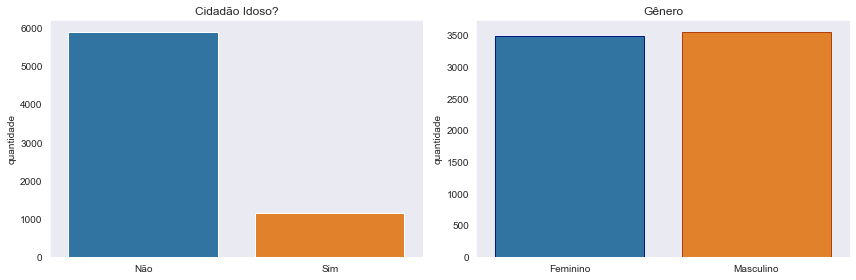

In [30]:
# gerando gráficos de barras das colunas 'SeniorCitizen' e 'gender'

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))

ax[0].set_title('Cidadão Idoso?')
sns.countplot('SeniorCitizen', data = df_clean, ax = ax[0])
ax[0].set_xticklabels(('Não', 'Sim'))
ax[0].set_xlabel('')
ax[0].set_ylabel('quantidade')

ax[1].set_title('Gênero')
sns.countplot('gender', data = df_clean, ax = ax[1], edgecolor = sns.color_palette('dark', 3))
ax[1].set_xticklabels(('Feminino', 'Masculino'))
ax[1].set_xlabel('')
ax[1].set_ylabel('quantidade')

plt.tight_layout()

Plotaremos gráficos de barras para as colunas em que alteramos anteriormente o valor 'No internet service' para 'No'.

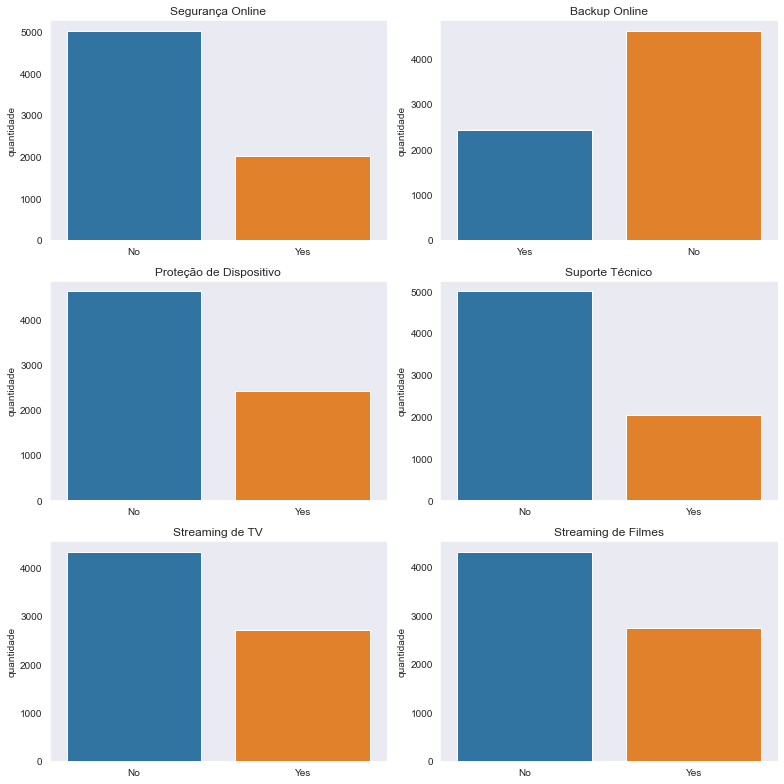

In [31]:
# gerando gráficos de barras para as colunas definidas

column_names = 'OnlineSecurity', \
               'OnlineBackup', \
               'DeviceProtection', \
               'TechSupport', \
               'StreamingTV', \
               'StreamingMovies'

column_names_pt = 'Segurança Online', \
                  'Backup Online', \
                  'Proteção de Dispositivo', \
                  'Suporte Técnico', \
                  'Streaming de TV', \
                  'Streaming de Filmes'

fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (11,11))
fig.subplots_adjust(hspace = 1, wspace = 1)

ind = 0
for col, col_pt in zip(column_names, column_names_pt):
    ind += 1
    plt.subplot(3, 2, ind)
    sns.countplot(df_clean[col])
    plt.title(col_pt)
    plt.ylabel('quantidade')
    plt.xlabel('')
plt.tight_layout()

### Churn

Neste conjunto de dados, a coluna 'Churn' indica quando um cliente cancelou a sua assinatura com a operadora de telecomunicação. Veremos agora a quantidade de clientes que cancelaram e a de clientes que continuam com a assinatura.

In [32]:
# obtendo a porcentagem de 'Yes' e 'No' da coluna 'Churn'

print(round((df_clean.Churn.value_counts() / df_clean.shape[0]) * 100, 2))

No     73.46
Yes    26.54
Name: Churn, dtype: float64


Como vimos, 26,54% dos clientes registrados nos dados que estamos analisando cancelaram as suas assinaturas. Plotaremos um gráfico de barras para vermos graficamente essa informação.

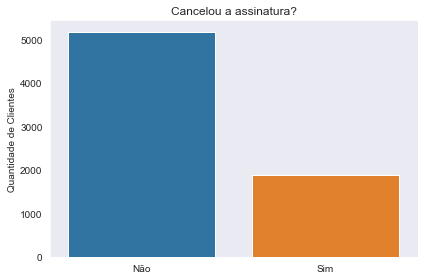

In [33]:
# plotando um gráfico de barras da coluna 'Churn'

fig, ax = plt.subplots()
ax.set_title('Cancelou a assinatura?')
sns.countplot('Churn', data = df_clean, ax = ax)
ax.set_xticklabels(('Não', 'Sim'))
ax.set_xlabel('')
ax.set_ylabel('Quantidade de Clientes')

plt.tight_layout()

In [34]:
# exportando dados alterados para um novo dataset

df_clean.to_csv('datasets/churn_cleaned.csv', index = False)